In [1]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from lib.functions import LogisticRegression
import lib.load_datasets as load_datasets
from lib.compressions import *
from lib.gradient_descent import *

In [2]:
X, y = load_datasets.dataset_to_X_y('diabetes.csv', normalize=True, nrows=500)
# X, y = make_blobs(n_samples=500, centers=2, n_features=5, random_state=0)
function = LogisticRegression(X, y)
dim = function.getDimention()
alpha = 0.0001 # for diabetes
# alpha = 0.04 # for make_blobs
print(dim)

9


In [4]:
base_experiments = [
    compressedGD(function, compressor=NoneCompressor(dim=dim), alpha=alpha),
    compressedGD(function, compressor=TopKCompressor(dim=dim, alpha=0.33), alpha=alpha),
    compressedGD(function, compressor=TopKCompressor(dim=dim, alpha=0.5), alpha=alpha),
    compressedGD(function, compressor=RandKCompressor(dim=dim, alpha=0.33), alpha=alpha),
    compressedGD(function, compressor=ReduceProbabilityCompressor(dim=dim, alpha=0.33, penalty=0.25), alpha=alpha),
    compressedGD(function, compressor=PenaltyCompressor(dim=dim, alpha=0.5, dropsTo=0.0, step=0.333), alpha=alpha),
    compressedGD(function, compressor=NewReduceProbabilityCompressor(dim=dim, alpha=0.5, penalty=0.5), alpha=alpha),
    compressedGD(function, compressor=TopUnknownCompressor(dim=dim, beta=1), alpha=alpha),
]

In [5]:
marina_experiments = [
    compressedGD(function, compressor=MarinaCompressor(dim=dim, p=0.5, compressor=TopKCompressor(dim=dim, alpha=0.5)), alpha=alpha),
    compressedGD(function, compressor=MarkovRandKCompressor(dim=dim, alpha=0.33, penalty=0.25), alpha=alpha),
]

In [3]:
new_experiments = [
    compressedGD(
        function,
        compressor=RandomizedKCompressor(
            dim=dim, compressor=TopKCompressor(dim=dim, alpha=0.5), minAlpha=0.2, maxAlpha=0.6
        ),
        alpha=alpha
    ),
]

In [6]:
experiments = base_experiments + marina_experiments + new_experiments
experiments.sort(key=lambda exp : exp['coords'][-1])

table = [
    ["compression", "num_iter", "transmitted coordinates"],
    *[
        [exp['name'], exp['num_iter'], exp['coords'][-1]]
        for exp in experiments
    ]
]
print(tabulate(table))

--------------------------------------------  --------  -----------------------
compression                                   num_iter  transmitted coordinates
TopK, alpha=0.5                               3321      13284
RandomizedKCompressor, (0.2, 0.6)             4410      13286
TopK, alpha=0.33                              6648      13296
TopUnknown, beta=1                            10540     13304
ReduceProbability, alpha=0.33, penalty=0.25   7149      14298
Marina, p=0.5, compressor=TopK, alpha=0.5     2309      14941
NewReduceProbability, alpha=0.5, penalty=0.5  4414      17656
Penalty, alpha=0.5, dropsTo=0.0, step=0.333   4652      18608
Markov RandK, alpha=0.33, penalty=0.25        10359     20718
Without compression                           2309      20781
RandK, alpha=0.33                             10572     21144
--------------------------------------------  --------  -----------------------


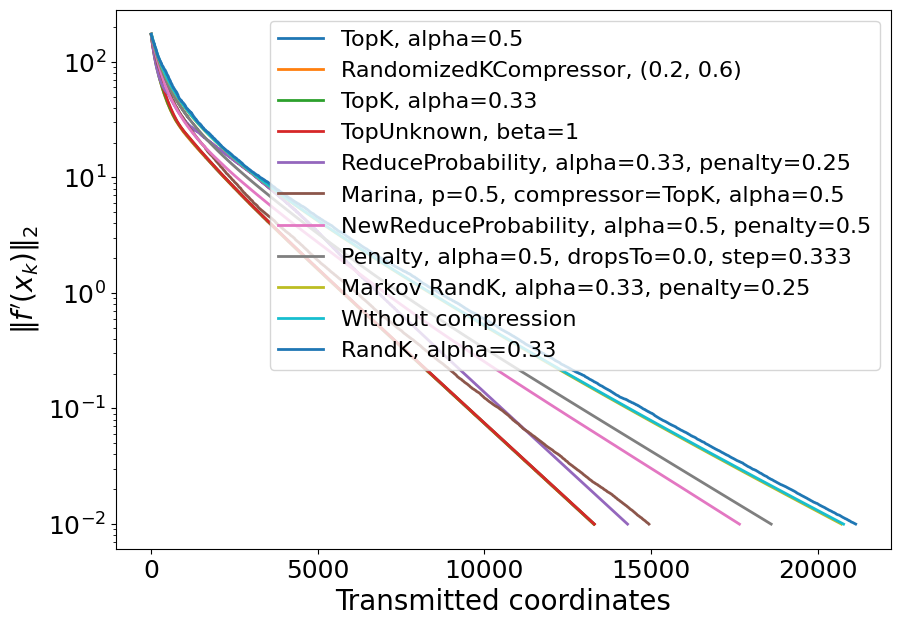

In [7]:
plt.figure(figsize=(10, 7))
for exp in experiments:
    plt.semilogy(
        exp['coords'],
        [grad_norm for grad_norm in exp['gradients']],
        label=exp['name'],
        linewidth=2
    )
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Transmitted coordinates", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)